# PKPD AL Weight Calibration

# Trying to figure out why AL efficacy is low despite adjusting dosage and blood volume

<br>

### Today's Date: 03/25
### Today's Agenda: 
1. Replicate efficacy graph with 10k patients
2. Plot graphs by weight group/individual patients to try and figure out where things are going wrong

In [1]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
from timeit import default_timer as timer
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys

In [2]:
#Get working directory
os.getcwd()

'/home/venitha_b/Projects/2019-test-ppq-pk/plots/AL/pkpd_AL/pfcrt+pfmdr1/weight_groups/after_PMF_correction/v4'

<br>

# Task 1: Replicating efficacy graph with 10k patients
## Weights 6 to 60 in increments of 1kg (55 different weights)
## n = 10k

In [19]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 6
max_weight = 60

# Define pmax_art values
weight_values = list(range(min_weight, max_weight+1, 1))
print(weight_values)
print(len(weight_values))

#Saving EC50_lum for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range_01.txt', weight_values, delimiter=',', fmt='%5f')

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))

[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]
55


In [20]:
def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "--pmax_artemether","0.999999",
        "-n", "100",
        "--weight", str(weight),
        "-o", "1"
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10)].shape[0]
        total_patients = df_weight['PID'].nunique()
        efficacy = (100 - ((failed_treatment_count / total_patients) * 100)) if total_patients > 0 else 0

        return (idx, efficacy)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for pmax_art: {weight}: {e}")
        return (idx, np.nan)  # Return NaN in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the clearance_rates array with the results
for idx, efficacy in results:
    trial_efficacy[idx] = efficacy

# Create a DataFrame with pmax_values and clearance_rates
df = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file

df.to_pickle("pkpd_AL_weight_calibration_01.pyobj")

# Save the DataFrame to a CSV file
df.to_csv("pkpd_AL_weight_calibration_01.csv", index=False)

print("DataFrame saved as pickle and CSV files successfully.")

Running simulations: 100%|██████████| 55/55 [00:15<00:00,  3.49it/s]

DataFrame saved as pickle and CSV files successfully.


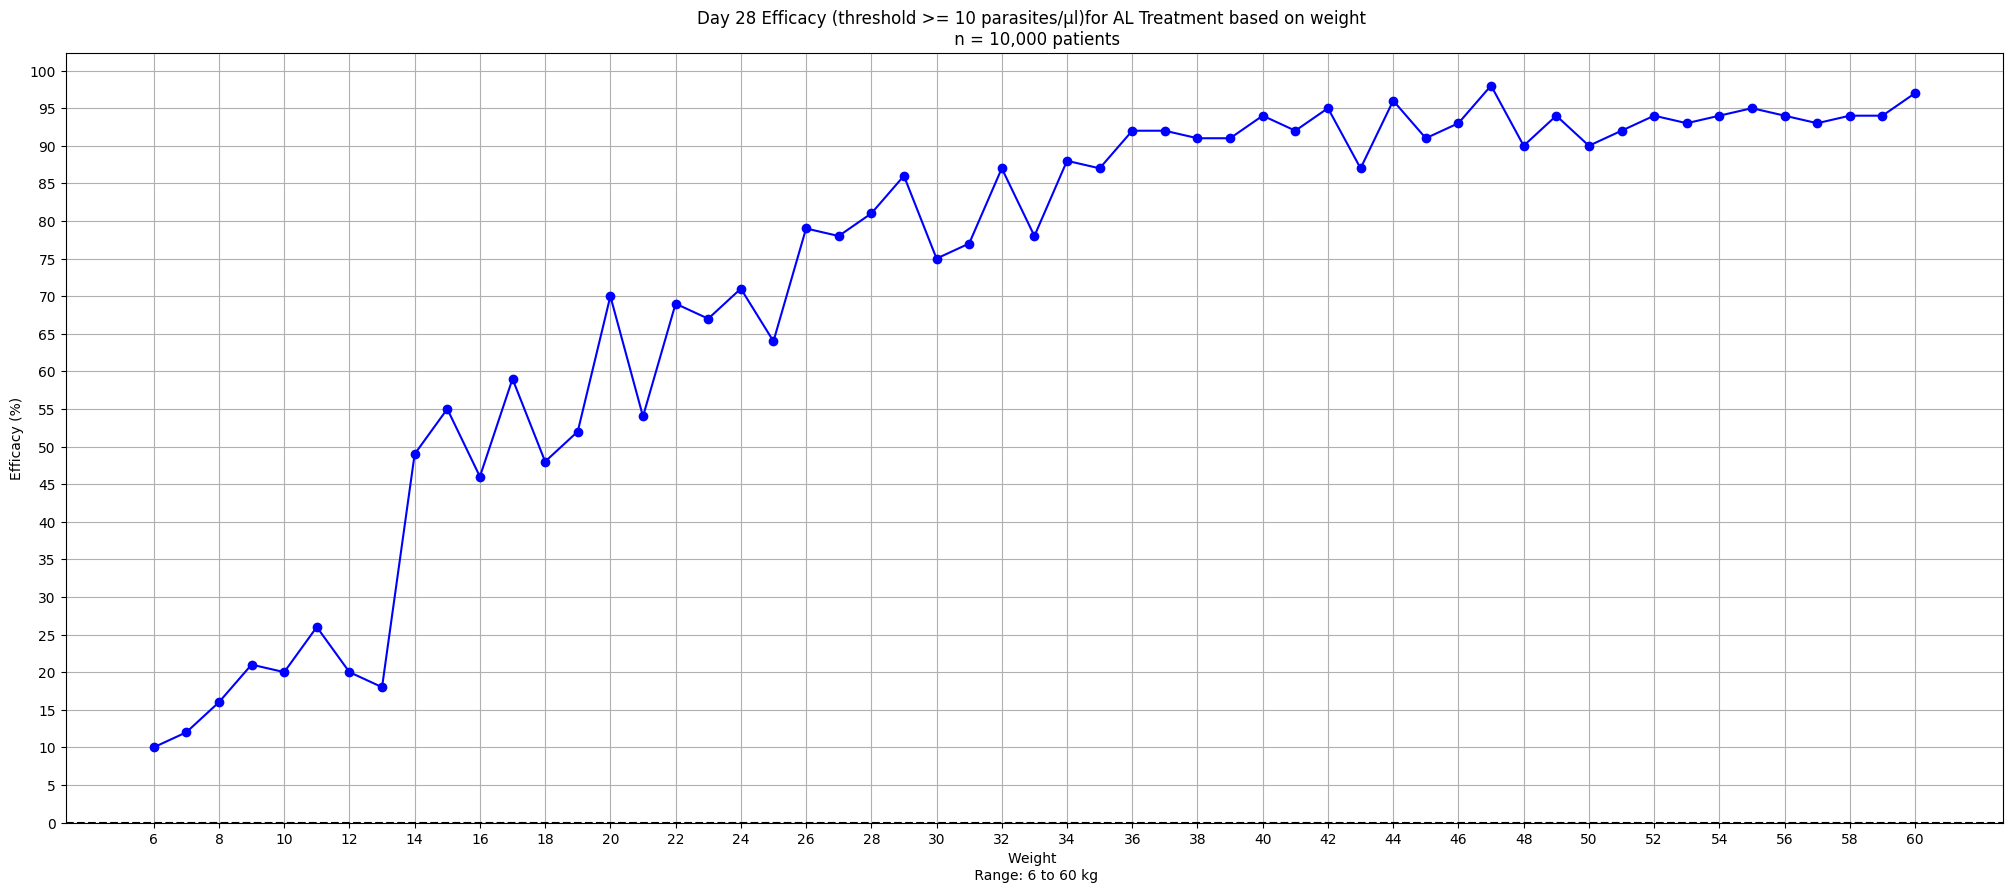

In [21]:
plt.figure(figsize=(25, 10))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 6 to 60 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl)for AL Treatment based on weight \n n = 10,000 patients")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 2))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 5))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_01.png")  # Save the plot as a PNG file
plt.show()

<br>

### Today's Date: 03/26

### Yesterday's Agenda:
1. ~~Replicate efficacy graph with 10k patients~~ **COMPLETED, CONGRATULATIONS!**
2. Plot graphs by weight group/individual patients to try and figure out where things are going wrong. **PENDING**

### Today's Agenda: 
1. Continue pending task from previous day's agenda: 

    * Plot graphs by weight group/individual patients to try and figure out where things are going wrong
        * ~~Tip: Check e-mail~~
<br>

#### Current goal: Analyze individual patient data to understand why lower weights have lower efficacy

* Take four sample individuals and plot their detailed curves
* Patients of weight: 6, {12, 13, 14}, {22, 23, 24}, {32, 33, 34}, 54
* ~~Let's try to simulate 1k patients of weights between 12 and 14 and plot their graphs~~
    * Actually let's try a larger range: {10,16}
* Not sure if analyzing individual patients in this range will be informative

In [3]:
# Pasting these here for easier access

import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolacors
import pickle
from tqdm import tqdm  # For progress bar
from multiprocessing import Pool, cpu_count
import os
import sys
import time
import datetime 

In [3]:
# Checking if we are in the correct directory
#wd()

# Define the range for weight groups
min_weight = 9
max_weight = 17

# Define values
weight_values = list(range(min_weight, max_weight+1, 1))

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Initialize a grid to store the clearance rates
trial_efficacy = np.zeros(len(weight_values))

# Initialize a list to store the DataFrames
dataframes_results = []

print(weight_values)
print(len(weight_values))

#Saving weights for future reference
np.savetxt('pkpd_AL_weight_calibration_weight_range_group_01.txt', weight_values, delimiter=',', fmt='%5f')

[9, 10, 11, 12, 13, 14, 15, 16, 17]
9


- Just realized that the pkpd_model simulates patients of one weight for all n number of patients instead of a range
* Change the functionality later

- ~~Let's also use this opportunity to make sure the function runs as intended (can you imagine if it doesn't?)~~
    - Look's accurate...

- ~~To-do: Note the date, time and duration for each simulation~~
    - Done


In [4]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_simulation(idx, weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Save the DataFrame to a CSV file
        df_weight.to_csv(f"df_weight_group_01_run_{idx+1}.csv", index=False)

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            # Example efficacy calculation:
            # failed_treatment_count = 10
            # total_patients = 100
            # percentage_failed = (failed_treatment_count/total_patients) * 100
            #                   = (10/100) * 100
            #                   = 10%

            # efficacy          = 100 - percentage_failed
            #                   = 100 - 10
            #                   = 90%
        
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            #efficacy = (100 - ((failed_treatment_count / total_patients) * 100))
            if np.isnan(efficacy):
                efficacy = np.nan
        return (idx, efficacy, df_weight, failed_treatment_count)

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return (idx, np.nan, None, 0)  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return (idx, np.nan, None, 0)  # Return NaN, None, and 0 in case of failure

# Define number of workers (use all available CPU cores)
num_workers = cpu_count()

# Prepare a list of parameters to pass to the pool
params_list = [(i, weight_values[i]) for i in range(len(weight_values))]

# Initialize an array to store the efficacies
trial_efficacy = np.zeros(len(weight_values))

# Initialize a list to store the DataFrames
dataframes_results = []
failed_patients = np.zeros(len(weight_values))

# Run simulations in parallel and track progress
with Pool(processes=num_workers) as pool:
    results = []
    with tqdm(total=len(params_list), desc="Running simulations") as pbar:
        for result in pool.starmap(run_simulation, params_list):
            results.append(result)
            pbar.update(1)  # Update progress bar after each result

# Update the trial_efficacy array with the results and store DataFrames
for idx, efficacy, df_weight, failed_treatment_count in results:
    trial_efficacy[idx] = efficacy
    failed_patients[idx] = failed_treatment_count
    dataframes_results.append(df_weight)

# Create a DataFrame with weight values and efficacies
df_efficacy = pd.DataFrame({
    'weight': weight_values,
    'efficacy': trial_efficacy
})

# Save the DataFrame to a pickle file
df_efficacy.to_pickle("pkpd_AL_weight_calibration_group_01.pyobj")

# Save the DataFrame to a CSV file
df_efficacy.to_csv("pkpd_AL_weight_calibration_group_01.csv", index=False)

#Saving failed patient count for future reference
np.savetxt('pkpd_AL_weight_calibration_group_01_patient_failure.txt', failed_patients, delimiter=',', fmt='%2f')

print("DataFrame saved as pickle and CSV files successfully.")

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ",today, "\n")
print("Length of simulation: ",datetime.timedelta(seconds=end_time - start_time), "\n")

Running simulations: 100%|██████████| 9/9 [09:26<00:00, 62.97s/it]   

DataFrame saved as pickle and CSV files successfully.

Today's date:  2025-03-27 

Length of simulation:  0:09:26.817165 



In [6]:
# Checking how df_efficacy looks like
df_efficacy

,weight,efficacy
0,9,6.03
1,10,5.81
2,11,6.50
3,12,6.75
4,13,7.46
5,14,19.76
6,15,19.68
7,16,21.20
8,17,22.49


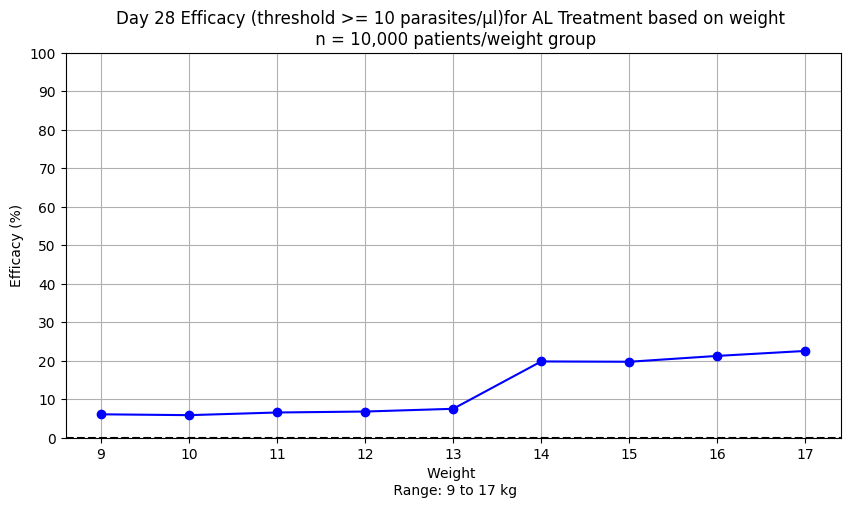

In [7]:
# Massive jump in efficacy between weights 13 and 14

# Let's plot this as a graph

plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
plt.plot(weight_values, trial_efficacy, marker='o', linestyle='-', color='b')
plt.xlabel('Weight \n Range: 9 to 17 kg')
plt.ylabel('Efficacy (%)')
plt.title("Day 28 Efficacy (threshold >= 10 parasites/μl)for AL Treatment based on weight \n n = 10,000 patients/weight group")
plt.grid(True)
plt.xticks(np.arange(min(weight_values), max(weight_values)+1, 1))  # Adjust tick marks if necessary
plt.yticks(np.arange(0, 101, 10))  # Y-axis ticks from 0 to 100%
plt.axhline(y=0, color='k', linestyle='--')  # Optional: horizontal line at y=0
plt.savefig("pkpd_AL_weight_calibration_grpup_01.png")  # Save the plot as a PNG file
plt.show()

In [24]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 9  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_9kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_9kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  9443
The percentage efficacy is:  5.569999999999993

Today's date:  2025-03-27 

Length of simulation:  0:04:12.411062 



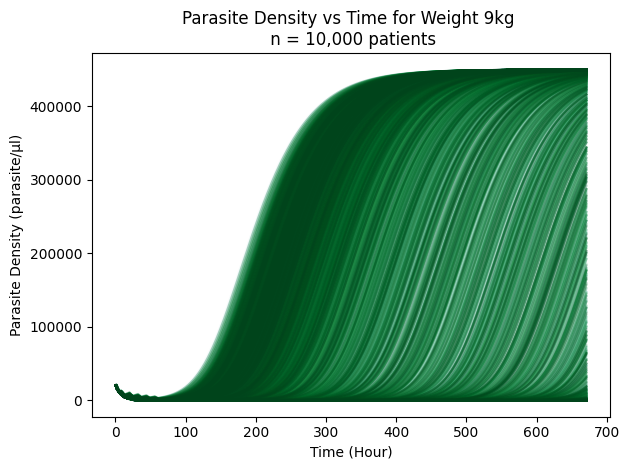

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasite/μl)')
plt.title("Parasite Density vs Time for Weight 9kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_9kg_parasitedensity_01.png")
plt.tight_layout()
plt.show()

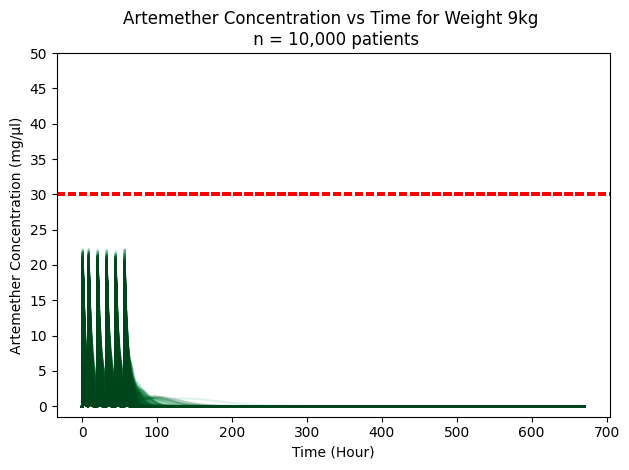

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)
    
    # Draw line at 30mg, total dose for 13kg
    plt.axhline(y=30, color='r', linestyle='--')
    plt.yticks(range(0, 51, 5))  # Set y-axis ticks from 0 to 50 with a step of 5


#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration (mg/μl)')
plt.title("Artemether Concentration vs Time for Weight 9kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_9kg_art_01.png")
plt.tight_layout()
plt.show()

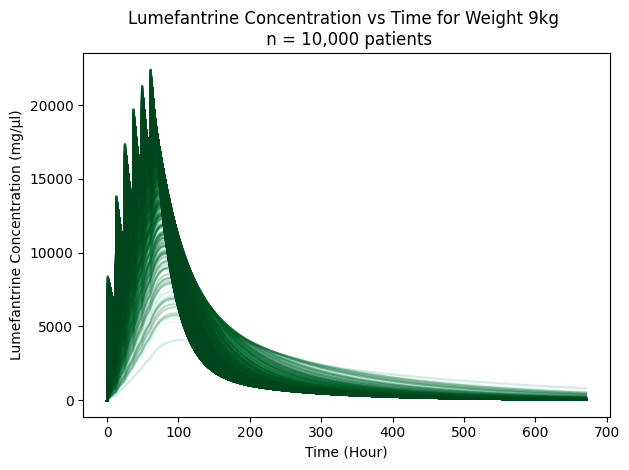

In [27]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration (mg/μl)')
plt.title("Lumefantrine Concentration vs Time for Weight 9kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_9kg_lum_01.png")
plt.tight_layout()
plt.show()

In [28]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 13  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_13kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_13kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  9263
The percentage efficacy is:  7.3700000000000045

Today's date:  2025-03-27 

Length of simulation:  0:04:09.026380 



In [4]:
df_weight_parasite_density_wide = df_weight.pivot(index="PID", columns="HOUR", values="PARASITEDENSITY")
df_weight_art_concentration_wide = df_weight.pivot(index="PID", columns="HOUR", values="COMP2CONC_ART")
df_weight_lum_concentration_wide = df_weight.pivot(index="PID", columns="HOUR", values="COMP2CONC_LUM")

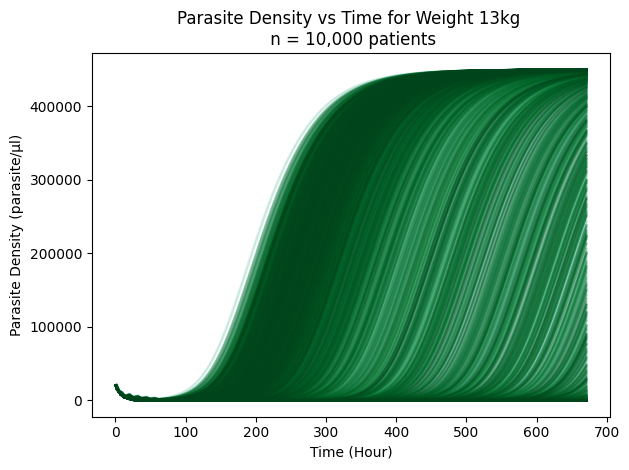

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasite/μl)')
plt.title("Parasite Density vs Time for Weight 13kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_13kg_parasitedensity_01.png")
plt.tight_layout()
plt.show()

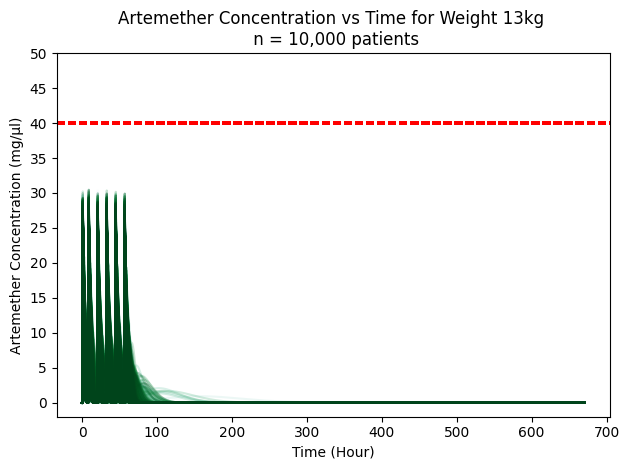

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)
    
    # Draw line at 40mg, total dose for 13kg
    plt.axhline(y=40, color='r', linestyle='--')
    plt.yticks(range(0, 51, 5))  # Set y-axis ticks from 0 to 50 with a step of 5


#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration (mg/μl)')
plt.title("Artemether Concentration vs Time for Weight 13kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_13kg_art_01.png")
plt.tight_layout()
plt.show()

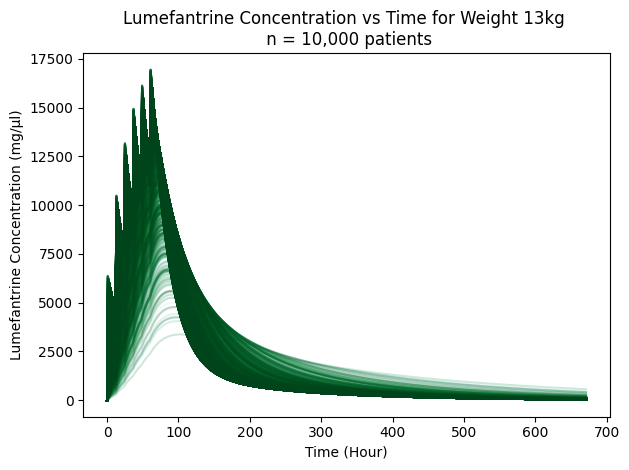

In [31]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration (mg/μl)')
plt.title("Lumefantrine Concentration vs Time for Weight 13kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_13kg_lum_01.png")
plt.tight_layout()
plt.show()

In [32]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 14  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_14kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_14kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  8042
The percentage efficacy is:  19.58

Today's date:  2025-03-27 

Length of simulation:  0:04:06.349345 



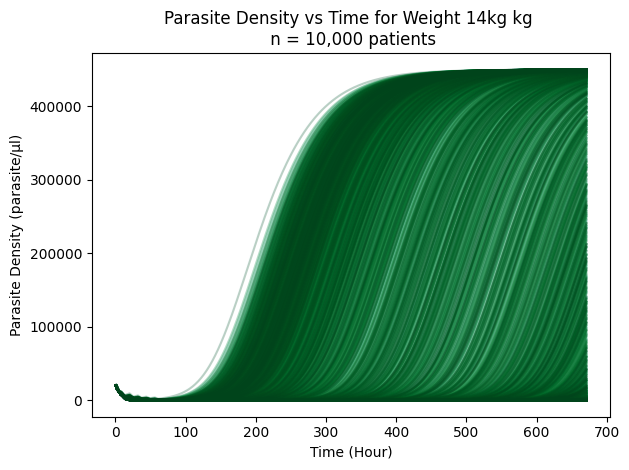

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasite/μl)')
plt.title("Parasite Density vs Time for Weight 14kg kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_14kg_parasitedensity_01.png")
plt.tight_layout()
plt.show()

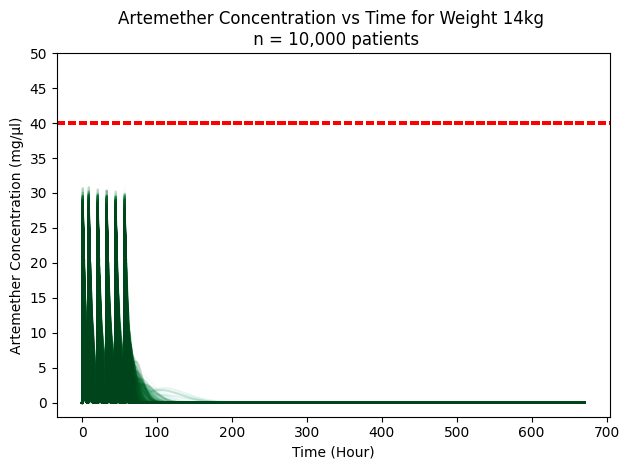

In [34]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)

    # Draw line at 40mg, total dose for 14kg
    plt.axhline(y=40, color='r', linestyle='--')
    plt.yticks(range(0, 51, 5))  # Set y-axis ticks from 0 to 50 with a step of 5
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration (mg/μl)')
plt.title("Artemether Concentration vs Time for Weight 14kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_14kg_art_01.png")
plt.tight_layout()
plt.show()

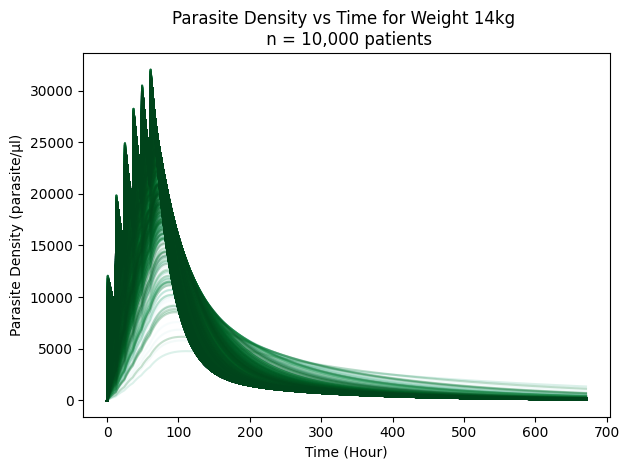

In [35]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasite/μl)')
plt.title("Parasite Density vs Time for Weight 14kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_14kg_lum_01.png")
plt.tight_layout()
plt.show()

In [15]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "10000",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 16  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_16kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_16kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  7921
The percentage efficacy is:  20.789999999999992

Today's date:  2025-03-27 

Length of simulation:  0:04:08.402655 



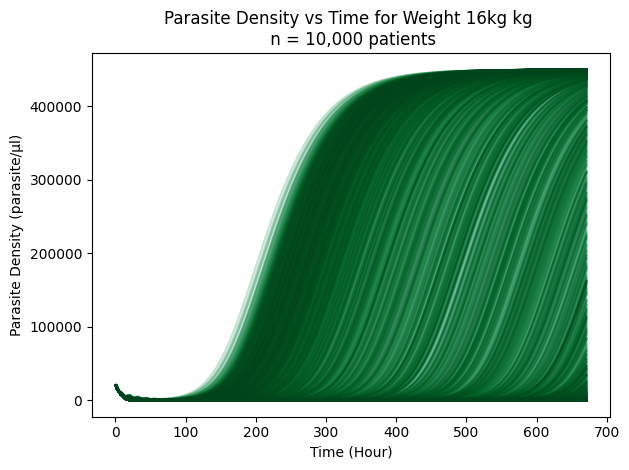

In [16]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasite/μl)')
plt.title("Parasite Density vs Time for Weight 16kg kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_16kg_parasitedensity_01.png")
plt.tight_layout()
plt.show()

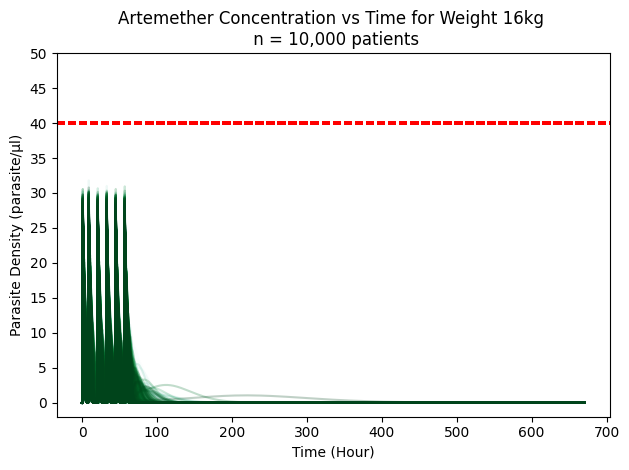

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)

    # Draw line at 40mg, total dose for 14kg
    plt.axhline(y=40, color='r', linestyle='--')
    plt.yticks(range(0, 51, 5))  # Set y-axis ticks from 0 to 50 with a step of 5
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration (mg/μl)')
plt.title("Artemether Concentration vs Time for Weight 16kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_16kg_art_01.png")
plt.tight_layout()
plt.show()

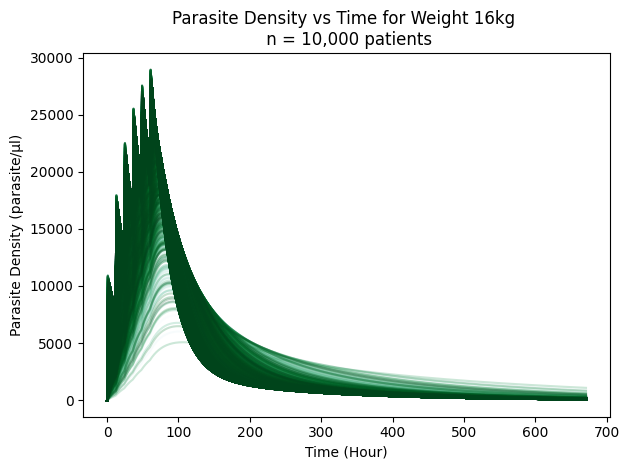

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration (mg/μl)')
plt.title("Lumefantrine Concentration vs Time for Weight 16kg \n n = 10,000 patients")
plt.savefig("pkpd_AL_weight_calibration_group_01_16kg_lum_01.png")
plt.tight_layout()
plt.show()

In [13]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "200",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 54  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_54kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_54kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  6
The percentage efficacy is:  97.0

Today's date:  2025-03-27 

Length of simulation:  0:00:04.815894 



In [14]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "500",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 50  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_50kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_50kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  24
The percentage efficacy is:  95.2

Today's date:  2025-03-27 

Length of simulation:  0:00:12.537767 



In [15]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "200",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 45  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_50kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_50kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  16
The percentage efficacy is:  92.0

Today's date:  2025-03-27 

Length of simulation:  0:00:04.604978 



In [16]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "500",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 37  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_50kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_50kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  51
The percentage efficacy is:  89.8

Today's date:  2025-03-27 

Length of simulation:  0:00:12.748724 



In [17]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "500",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 35  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_50kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_50kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  57
The percentage efficacy is:  88.6

Today's date:  2025-03-27 

Length of simulation:  0:00:12.784787 



In [18]:
# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "200",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 30  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_50kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_50kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  40
The percentage efficacy is:  80.0

Today's date:  2025-03-27 

Length of simulation:  0:00:05.260733 



In [22]:
#20

# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "3",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 20  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_20kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_20kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  2
The percentage efficacy is:  33.33333333333334

Today's date:  2025-03-27 

Length of simulation:  0:00:00.124470 



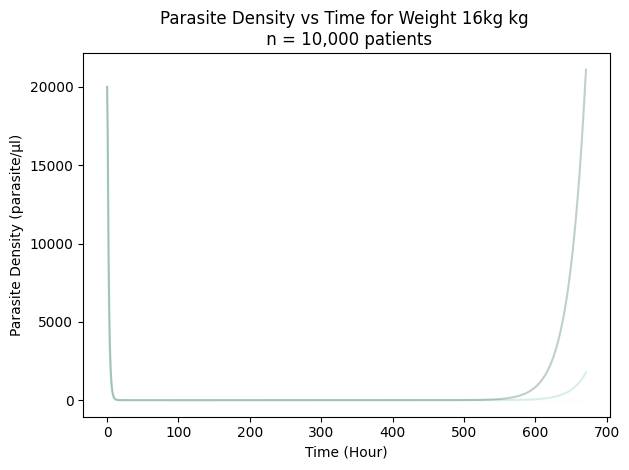

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasite/μl)')
plt.title("Parasite Density vs Time for Weight 20kg \n n = 3 patients")
#plt.savefig("pkpd_AL_weight_calibration_group_01_16kg_parasitedensity_01.png")
plt.tight_layout()
plt.show()

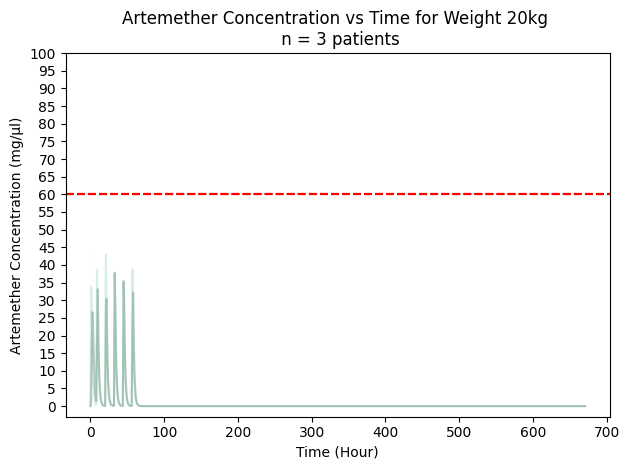

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)

    # Draw line at 40mg, total dose for 14kg
    plt.axhline(y=60, color='r', linestyle='--')
    plt.yticks(range(0, 101, 5))  # Set y-axis ticks from 0 to 50 with a step of 5
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration (mg/μl)')
plt.title("Artemether Concentration vs Time for Weight 20kg \n n = 3 patients")
#plt.savefig("pkpd_AL_weight_calibration_group_01_16kg_art_01.png")
plt.tight_layout()
plt.show()

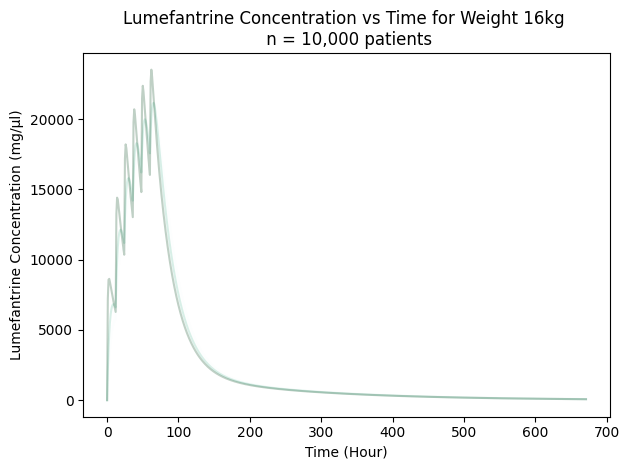

In [26]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())


# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    plt.plot(df_pid['HOUR'], df_pid['COMP2CONC_LUM'], color=color, alpha=0.25)
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration (mg/μl)')
plt.title("Lumefantrine Concentration vs Time for Weight 16kg \n n = 10,000 patients")
#plt.savefig("pkpd_AL_weight_calibration_group_01_16kg_lum_01.png")
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#Define the number of unique PIDs
num_pids = len(df_weight['PID'].unique())

nrows = 1
ncols = 1
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 8))

# Create a colormap
# Create a colormap
colormap = plt.get_cmap('BuGn')  # Ensure compatibility with different Matplotlib versions
norm = plt.Normalize(vmin=0, vmax=num_pids - 1)  # Normalize values to 0-1 range

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    axs.plot(df_pid['HOUR'], df_pid['PARASITEDENSITY'], color=color, alpha=0.25)
    #Set X and Y Labels for the entire plot
    axs.xlabel('Time (Hour)')
    axs.ylabel('Parasite Density (parasite/μl)')
    axs.title("Parasite Density vs Time for Weight 20kg \n n = 3 patients")

for j, pid in enumerate(df_weight['PID'].unique()):
    df_pid = df_weight[df_weight['PID'] == pid]
    color = colormap(norm(j))
    axs.plot(df_pid['HOUR'], df_pid['COMP2CONC_ART'], color=color, alpha=0.25)

    # Draw line at 40mg, total dose for 14kg
    plt.axhline(y=60, color='r', linestyle='--')
    plt.yticks(range(0, 101, 5))  # Set y-axis ticks from 0 to 50 with a step of 5
    
#Set X and Y Labels for the entire plot
plt.xlabel('Time (Hour)')
plt.ylabel('Artemether Concentration (mg/μl)')
plt.title("Artemether Concentration vs Time for Weight 20kg \n n = 3 patients")


#plt.savefig("pkpd_AL_weight_calibration_group_01_16kg_parasitedensity_01.png")
plt.tight_layout()
plt.show()

In [28]:
df_weight_group_01_20kg = pd.read_pickle("df_weight_group_01_20kg.pyobj")

In [31]:
df_weight_group_01_20kg_pid_1 = df_weight_group_01_20kg[df_weight_group_01_20kg['PID'] == 1]
df_weight_group_01_20kg_pid_2 = df_weight_group_01_20kg[df_weight_group_01_20kg['PID'] == 2]
df_weight_group_01_20kg_pid_3 = df_weight_group_01_20kg[df_weight_group_01_20kg['PID'] == 3]

df_weight_group_01_20kg_pid_1

,PID,HOUR,COMP2CONC_ART,COMP2CONC_LUM,PARASITEDENSITY
673,1,0.0,0.000,0.000,20000.000
674,1,1.0,33.767,2084.491,13564.697
675,1,2.0,28.381,3626.061,7975.360
676,1,3.0,14.361,4749.203,4695.432
677,1,4.0,7.219,5550.413,2766.706
...,...,...,...,...,...
1340,1,667.0,-0.000,74.764,1466.179
1341,1,668.0,-0.000,74.349,1537.290
1342,1,669.0,-0.000,73.937,1611.803
1343,1,670.0,-0.000,73.527,1689.877


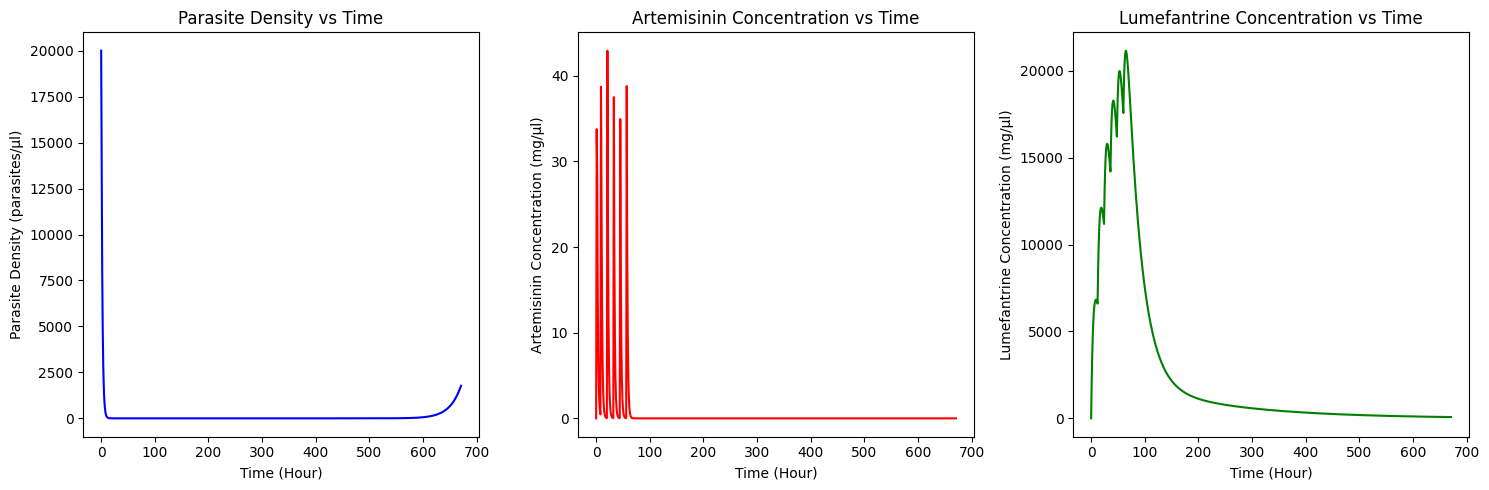

In [38]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(df_weight_group_01_20kg_pid_1['HOUR'], df_weight_group_01_20kg_pid_1['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
plt.plot(df_weight_group_01_20kg_pid_1['HOUR'], df_weight_group_01_20kg_pid_1['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemisinin Concentration (mg/μl)')
plt.title('Artemisinin Concentration vs Time')

plt.subplot(1, 3, 3)
plt.plot(df_weight_group_01_20kg_pid_1['HOUR'], df_weight_group_01_20kg_pid_1['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration (mg/μl)')
plt.title('Lumefantrine Concentration vs Time')

plt.tight_layout()
plt.show()


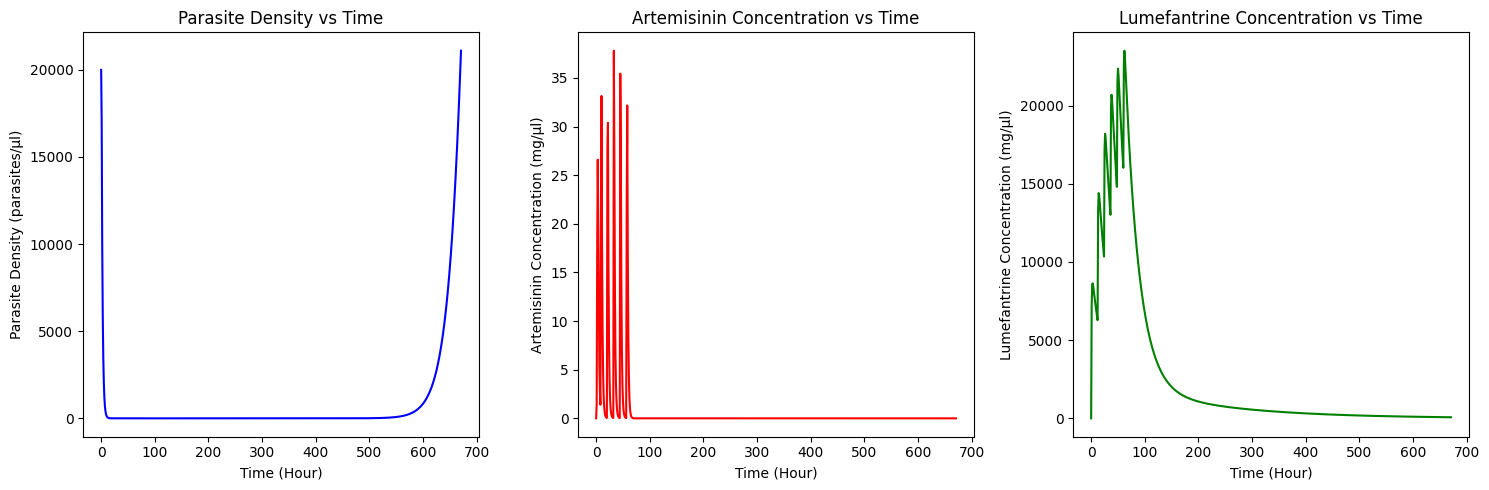

In [39]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(df_weight_group_01_20kg_pid_2['HOUR'], df_weight_group_01_20kg_pid_2['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
plt.plot(df_weight_group_01_20kg_pid_2['HOUR'], df_weight_group_01_20kg_pid_2['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemisinin Concentration (mg/μl)')
plt.title('Artemisinin Concentration vs Time')

plt.subplot(1, 3, 3)
plt.plot(df_weight_group_01_20kg_pid_2['HOUR'], df_weight_group_01_20kg_pid_2['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration (mg/μl)')
plt.title('Lumefantrine Concentration vs Time')

plt.tight_layout()
plt.show()


In [42]:
#20

# Function to run a single simulation for a given weight value
start_time = time.monotonic()

def run_single_weight_simulation(weight):
    command_weight = [
        "/home/venitha_b/Projects/2019-test-ppq-pk/build/run_ppq_pk",
        "--AL",
        "-n", "3",
        "--pmax_artemether", "0.999999",
        "--weight", str(weight)
    ]

    try:
        # Run the command and capture output
        output_weight = subprocess.run(command_weight, capture_output=True, text=True, check=True)

        # Process the output
        lines_weight = output_weight.stdout.splitlines()
        df_weight = pd.DataFrame([line.split(',') for line in lines_weight], columns=["PID", "HOUR", "COMP2CONC_ART", "COMP2CONC_LUM", "PARASITEDENSITY"])
        
        # Clean the DataFrame
        df_weight = df_weight.iloc[1:].apply(pd.to_numeric, errors='coerce')

        # Calculate the efficacy
        if df_weight['PARASITEDENSITY'].isna().any():
            failed_treatment_count = np.nan
        else:
            failed_treatment_count = df_weight[(df_weight['PARASITEDENSITY'] >= 10) & (df_weight['HOUR'] == 671.0)].shape[0]
        
        total_patients = df_weight['PID'].nunique()
        
        if total_patients == 0 or np.isnan(failed_treatment_count): 
            efficacy = np.nan
        else:
            percentage_failed = (failed_treatment_count / total_patients) * 100
            efficacy = (100 - percentage_failed)
            if np.isnan(efficacy):
                efficacy = np.nan
        return efficacy, df_weight, failed_treatment_count

    except subprocess.CalledProcessError as e:
        print(f"Error in subprocess for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure
    except Exception as e:
        print(f"An unexpected error occurred for weight: {weight}: {e}")
        return np.nan, None, 0  # Return NaN, None, and 0 in case of failure

# Define the single weight value to use
weight = 40  # Example weight value

# Run the simulation
efficacy, df_weight, failed_treatment_count = run_single_weight_simulation(weight)

# Save the DataFrame to a pickle file
df_weight.to_pickle("df_weight_group_01_40kg.pyobj")

# Save the DataFrame to a CSV file
df_weight.to_csv("df_weight_group_01_40kg.csv", index=False)


print("The failed treatment count is: ", failed_treatment_count)
print("The percentage efficacy is: ", efficacy)

end_time = time.monotonic()
today = datetime.date.today()
print("\nToday's date: ", today, "\n")
print("Length of simulation: ", datetime.timedelta(seconds=end_time - start_time), "\n")

The failed treatment count is:  0
The percentage efficacy is:  100.0

Today's date:  2025-03-27 

Length of simulation:  0:00:00.162519 



In [43]:
df_weight_group_01_40kg = pd.read_pickle("df_weight_group_01_40kg.pyobj")

In [44]:
df_weight_group_01_40kg_pid_1 = df_weight_group_01_40kg[df_weight_group_01_40kg['PID'] == 1]
df_weight_group_01_40kg_pid_2 = df_weight_group_01_40kg[df_weight_group_01_40kg['PID'] == 2]
df_weight_group_01_40kg_pid_3 = df_weight_group_01_40kg[df_weight_group_01_40kg['PID'] == 3]

df_weight_group_01_20kg_pid_1

,PID,HOUR,COMP2CONC_ART,COMP2CONC_LUM,PARASITEDENSITY
673,1,0.0,0.000,0.000,20000.000
674,1,1.0,33.767,2084.491,13564.697
675,1,2.0,28.381,3626.061,7975.360
676,1,3.0,14.361,4749.203,4695.432
677,1,4.0,7.219,5550.413,2766.706
...,...,...,...,...,...
1340,1,667.0,-0.000,74.764,1466.179
1341,1,668.0,-0.000,74.349,1537.290
1342,1,669.0,-0.000,73.937,1611.803
1343,1,670.0,-0.000,73.527,1689.877


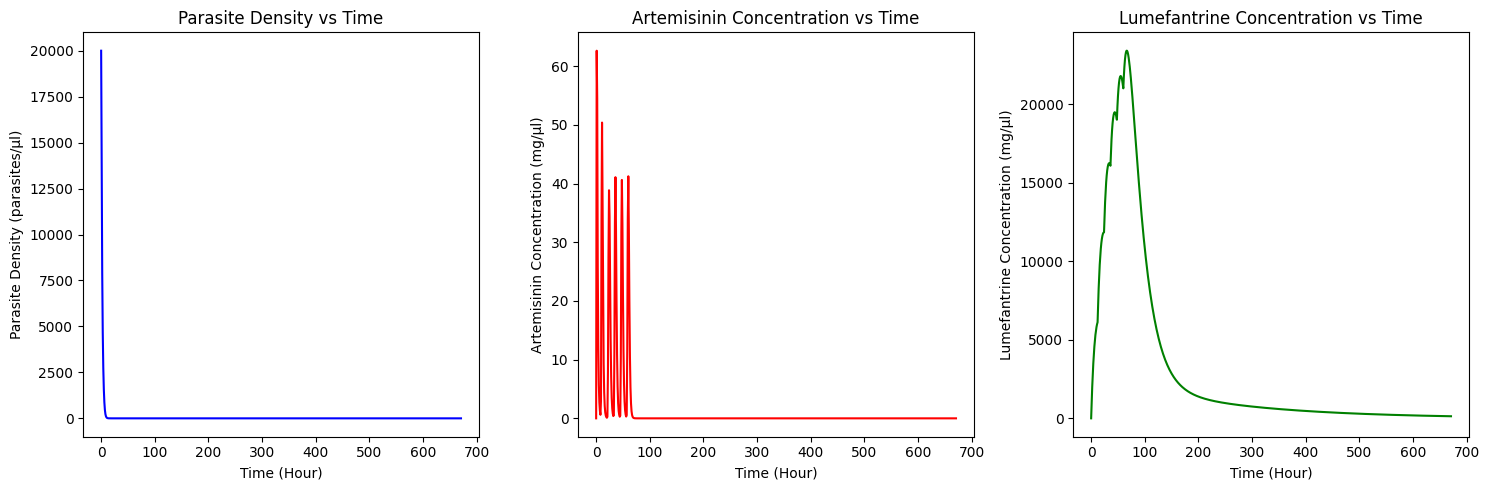

In [45]:
#Plot parasite density, artemisinin and lumefantrine concentration for weight group 2, run 2, patient weight = 8kg

import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(df_weight_group_01_40kg_pid_1['HOUR'], df_weight_group_01_40kg_pid_1['PARASITEDENSITY'], color='blue')
plt.xlabel('Time (Hour)')
plt.ylabel('Parasite Density (parasites/μl)')
plt.title('Parasite Density vs Time')

plt.subplot(1, 3, 2)
plt.plot(df_weight_group_01_40kg_pid_1['HOUR'], df_weight_group_01_40kg_pid_1['COMP2CONC_ART'], color='red')
plt.xlabel('Time (Hour)')
plt.ylabel('Artemisinin Concentration (mg/μl)')
plt.title('Artemisinin Concentration vs Time')

plt.subplot(1, 3, 3)
plt.plot(df_weight_group_01_40kg_pid_1['HOUR'], df_weight_group_01_40kg_pid_1['COMP2CONC_LUM'], color='green')
plt.xlabel('Time (Hour)')
plt.ylabel('Lumefantrine Concentration (mg/μl)')
plt.title('Lumefantrine Concentration vs Time')

plt.tight_layout()
plt.show()
